# Introduction

This notebook serves to replicate Oliver's results with his tensorflow model on a dataset with zero overlap conditions. We'll be testing the simplified version of the model where there are zero overlaps.

In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')
import numpy as np
import importlib

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset
from tensordict import TensorDict, TensorDictBase

import lightning as L
import mlflow.pytorch
from mlflow import MlflowClient

from ptycho_torch.dset_loader_pt_mmap import PtychoDataset
from ptycho_torch.model import PtychoPINN
import ptycho_torch.helper as hh

import matplotlib.pyplot as plt



/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We're going to try MAE loss first just to take the Poisson scaling out of the equation.

In [2]:
from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

data_config_default = {
    'nphotons': 1e5,
    'N': 64,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
    'normalize': False
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 10000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': False, #True if need patch reassembly
    'probe.big': False, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'MAE'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

In [3]:
from ptycho_torch.model import Autoencoder

In [4]:
torch.manual_seed(2208707539130493126)
autoenc = Autoencoder(2)

In [5]:
autoenc

Autoencoder(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): ConvPoolBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (1): ConvPoolBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (2): ConvPoolBlock(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
      )
    )
  )
  (decoder_amp): Decoder_amp(
  

In [6]:
torch.manual_seed(42)
test_tensor = torch.randn((64, 1, 64, 64))

out_amp, out_phase = autoenc(test_tensor)

In [7]:
out_amp.shape

torch.Size([64, 1, 64, 64])

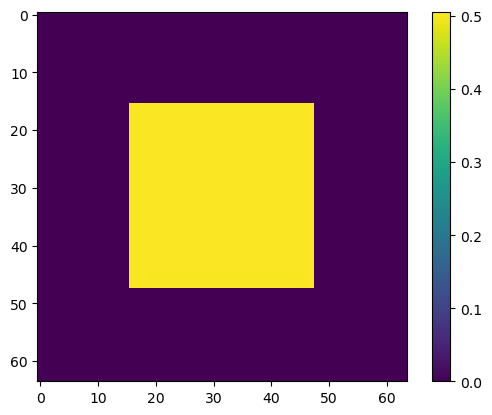

In [8]:
plt.imshow(out_amp[0,0,:,:].detach().numpy())
plt.colorbar()

# Modifying Oliver's Dataset

We're going to create an artifical dataset from "lines_no_overlap.npz". 

We technically only need X (diffraction stack) and probe (probe). The other fields that are typically in the dataset (such as xcoords, ycoords) do not need to be populated as they start empty after initialization. We have modified dataset.py to only load these fields if object.big = True

In [16]:
test = np.load('ptycho_torch/datasets/lines_no_overlap.npz')
test.files

['X',
 'Y_I',
 'Y_phi',
 'norm_Y_I',
 'YY_full',
 'coords_nominal',
 'coords_true',
 'nn_indices',
 'global_offsets',
 'local_offsets',
 'probe']

In [ ]:
#Histogram the values in test['X'][:100]

c, b = np.histogram(test['X'][:100])


array([0.       , 0.6142169, 1.2284338, 1.8426509, 2.4568677, 3.0710847,
       3.6853018, 4.2995186, 4.9137354, 5.5279527, 6.1421695],
      dtype=float32)

In [ ]:
c_p, b_p = np.histogram(np.abs(test['probe']))

(array([3628,   28,   40,    8,   16,   24,   20,   16,   24,  292]),
 array([1.0893617e-09, 1.0893617e-01, 2.1787234e-01, 3.2680851e-01,
        4.3574467e-01, 5.4468083e-01, 6.5361702e-01, 7.6255316e-01,
        8.7148935e-01, 9.8042548e-01, 1.0893617e+00], dtype=float32))

Originally, the shape of the diffraction images is channel last, so we need to transpose it to the second dimension.

Also, the probe has a dummy empty third dimension, so we squeeze to remove it

In [ ]:
np.savez('ptycho_torch/datasets/lines_no_overlap_diff/lines_modified.npz',
        diff3d = test['X'].squeeze())

np.savez('ptycho_torch/datasets/probes_lines/probe1.npz',
        probe = test['probe'].squeeze())

# Constructing the dataset/dataloaders

The datasets in question are located as follows:

1. Diffraction stack: ptycho_torch/datasets/lines_no_overlap_diff
2. Probe: ptycho_torch/datasets/probes_lines

In [3]:
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader

In [4]:
test_dset = PtychoDataset('ptycho_torch/datasets/lines_no_overlap_diff',
                          'ptycho_torch/datasets/probes_lines',
                          remake_map = True)

['probe1.npz']
Creating memory mapped tensor dictionary...
Memory map length: 13778
Memory map creation time: 0.008576154708862305
Populating memory map for dataset 0
Non-diffraction memory map write time: 0.004967212677001953
Diffraction memory map write time: 4.55443811416626


In [5]:
testloader = TensorDictDataLoader(test_dset, batch_size = 64)

In [6]:
test_iter = next(iter(testloader))

# Training

Here, we will train the Pytorch Lightning version of the PtychoPINN model, which we import from train.py.

The script we have here mirrors the main() script in train.py

In [14]:
from ptycho_torch.train import PtychoPINN
from ptycho_torch.train import Collate, print_auto_logged_info
from ptycho_torch.config_params import ModelConfig, TrainingConfig, DataConfig
from ptycho_torch.config_params import data_config_default, model_config_default, training_config_default
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader, PtychoDataset

In [9]:
os.getcwd()

'/home/av_linux/PtychoPINN'

In [12]:
#Check if directory "ptycho_torch" exists
os.path.exists("ptycho_torch/datasets/lines_no_overlap_diff")

True

In [15]:
#Define directory paths
#All experiment npz files are separate files in the ptycho_dir
#All probe npz files are separate files in the probe_dir
ptycho_dir = 'ptycho_torch/datasets/lines_no_overlap_diff'
probe_dir = 'ptycho_torch/datasets/probes_lines'

#Define configs
print('Loading configs...')
modelconfig = ModelConfig()
trainingconfig = TrainingConfig()
dataconfig = DataConfig()

#Set configs
modelconfig.set_settings(model_config_default)
trainingconfig.set_settings(training_config_default)
dataconfig.set_settings(data_config_default)

#Modify specific settings here
#We're changing the default image size to 64, removing normalization, and removing overlap condition
dataconfig.add('N', 64)
dataconfig.add('normalize', False)

modelconfig.add('object.big', False)
modelconfig.add('probe.big', False)


#Creating dataset
print('Creating dataset...')
ptycho_dataset = PtychoDataset(ptycho_dir, probe_dir, remake_map=True)

#Dataloader
print('Creating dataloader...')
train_loader = TensorDictDataLoader(ptycho_dataset, batch_size = 64,
                                    collate_fn = Collate(device = TrainingConfig().get('device')))

#Create model
print('Creating model...')
model = PtychoPINN()
model.training = True

#Create trainer
trainer = L.Trainer(max_epochs = 20,
                    default_root_dir = os.path.dirname(os.getcwd()),
                    devices = 'auto',
                    accelerator = 'gpu',
                    gradient_clip_val = 10,
                    accumulate_grad_batches=5)

#Mlflow setup
# mlflow.set_tracking_uri("")
mlflow.set_experiment("PtychoPINN vanilla")

mlflow.pytorch.autolog(checkpoint_monitor = "mae_train_loss")

#Train the model
with mlflow.start_run() as run:
    print('Training model...')
    trainer.fit(model, train_loader)

print_auto_logged_info(mlflow.get_run(run_id = run.info.run_id))

Loading configs...
Creating dataset...
['probe1.npz']
Creating memory mapped tensor dictionary...
Memory map length: 13778
Memory map creation time: 0.0008711814880371094
Populating memory map for dataset 0
Non-diffraction memory map write time: 0.00017142295837402344


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024/11/07 13:27:47 INFO mlflow.tracking.fluent: Experiment with name 'PtychoPINN vanilla' does not exist. Creating a new experiment.
2024/11/07 13:27:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


Diffraction memory map write time: 2.0429317951202393
Creating dataloader...
Creating model...


2024-11-07 13:27:48.417437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 13:27:48.417504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 13:27:48.455043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 13:27:48.548747: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 13:27:49.658786: W tensorflow/compiler/tf2

Training model...


INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | autoencoder     | Autoencoder    | 2.3 M  | train
1 | combine_complex | CombineComplex | 0      | train
2 | forward_model   | ForwardModel   | 0      | train
3 | Loss            | MAELoss        | 0      | train
-----------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.313     Total estimated model params size (MB)
64        Modules in train mod

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
2024/11/07 13:30:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils."
2024/11/07 13:30:07 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


run_id: 97e051af86884749ab939f884e7cee46
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'capturable': 'False', 'fused': 'None', 'maximize': 'False', 'differentiable': 'False', 'weight_decay': '0', 'foreach': 'None', 'lr': '0.002', 'eps': '1e-08', 'optimizer_name': 'Adam', 'epochs': '20', 'amsgrad': 'False', 'betas': '(0.9, 0.999)'}
metrics: {'mae_train_loss_step': 570.7440185546875, 'mae_train_loss_epoch': 2156.2275390625, 'mae_train_loss': 2156.2275390625}
tags: {'Mode': 'training'}


# Evaluating model afterwards

Here we'll import the model based on run-id and see the quality of some reconstructions

In [7]:
run_id = '0ed50ade69d0402abe19054c922cf3fb'
loaded_model = mlflow.pytorch.load_model(f"ptycho_torch/mlruns/677144611495216527/{run_id}/artifacts/model")

In [8]:
diff = test_iter[0]['images'].to('cuda')
positions = test_iter[0]['coords_relative'].to('cuda')
probe = test_iter[1].to('cuda')
scaling = test_iter[2].to('cuda')

loaded_model.to('cuda')

PtychoPINN(
  (autoencoder): Autoencoder(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): ConvPoolBlock(
          (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (1): ConvPoolBlock(
          (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        )
        (2): ConvPoolBlock(
          (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilati

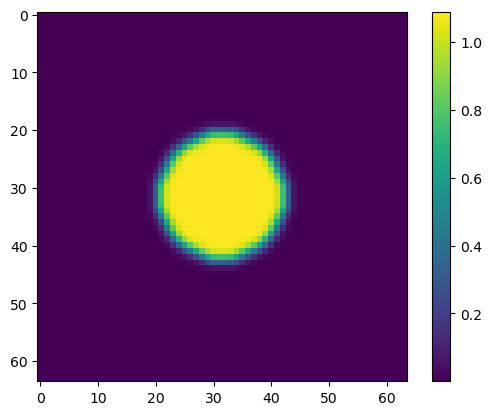

In [32]:
plt.imshow(test_iter[1][0][0].abs())
plt.colorbar()

In [9]:
#Use the test_iter from above
# loaded_model.eval()
# loaded_model.predict = False
# loaded_model.training = True

with torch.no_grad():
    #Prediction of diffraction pattern from input diffraction pattern
    test_pred = loaded_model(diff, positions, probe, scaling)
    #Prediction of object function from input diffraction pattern
    forward_pred = loaded_model.forward_predict(diff, positions, probe, scaling)

In [10]:
test_pred_cpu = test_pred.to('cpu')
test_pred_cpu = test_pred_cpu ** 2

test_pred_cpu.device, test_pred_cpu.dtype

forward_pred = forward_pred.to('cpu')

In [11]:
lines_no = np.load('ptycho_torch/datasets/lines_no_overlap.npz')

In [12]:
true_I = lines_no['Y_I']
true_phi = lines_no['Y_phi']

In [18]:
test_iter[1][0].shape

torch.Size([1, 64, 64])

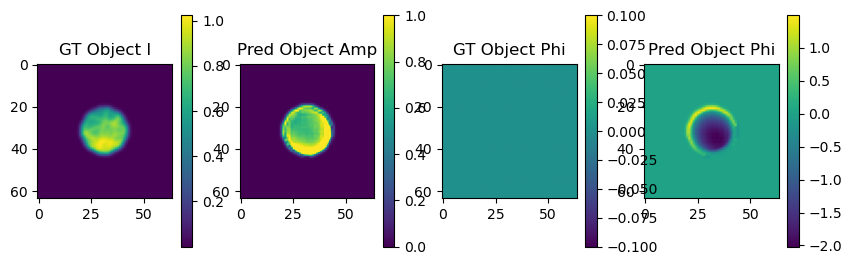

In [29]:
i = 0
fig, axs = plt.subplots(1, 4, figsize=(10,10))
#Predicted Diffraction
im0 = axs[0].imshow(true_I[i].squeeze())
axs[0].set_title('GT Object I')
fig.colorbar(im0, ax = axs[0], shrink = 0.3)
#Object function * probe function to remove dud edges
im1 = axs[1].imshow(forward_pred[i,0].abs() * test_iter[1][0][0].abs())
axs[1].set_title('Pred Object Amp')
fig.colorbar(im1, ax = axs[1], shrink = 0.3)
im1.set_clim(vmin=0, vmax = 1)
#Ground Truth Diffraction
im2 = axs[2].imshow(true_phi[i].squeeze())
axs[2].set_title('GT Object Phi')
fig.colorbar(im2, ax = axs[2], shrink = 0.3)
#Probe
im3 = axs[3].imshow(forward_pred[i,0].angle() * test_iter[1][0][0].abs())
axs[3].set_title('Pred Object Phi')
fig.colorbar(im3, ax = axs[3], shrink = 0.3)

Going to double check whether or not the forward model is working as intended...

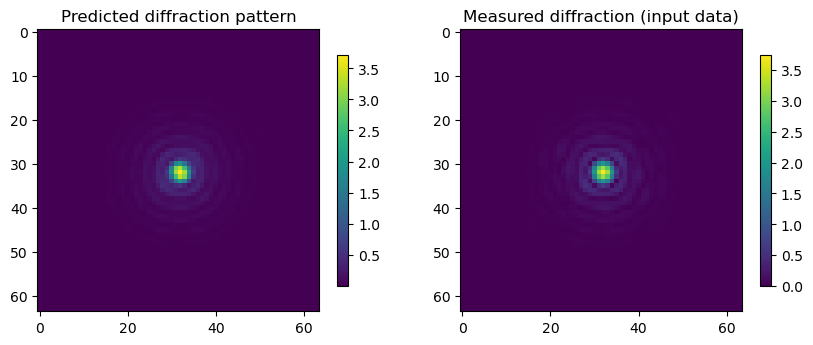

In [20]:
i = 5
fig, axs = plt.subplots(1, 2, figsize=(10,10))
#Predicted Diffraction
im0 = axs[0].imshow(test_pred_cpu[i,0].abs())
axs[0].set_title('Predicted diffraction pattern')
fig.colorbar(im0, ax = axs[0], shrink = 0.3)
#Measured diffraction (input data)
im1 = axs[1].imshow(diff[i,0].to('cpu').abs())
axs[1].set_title('Measured diffraction (input data)')
fig.colorbar(im1, ax = axs[1], shrink = 0.3)

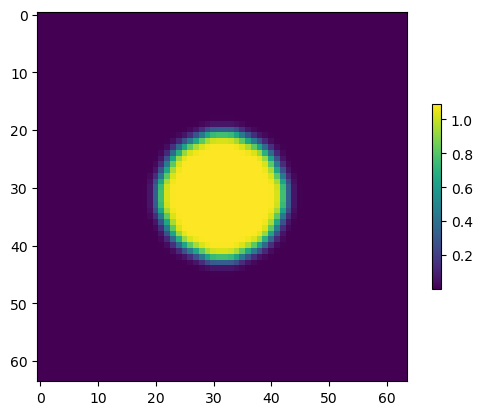

In [21]:
im = plt.imshow(probe[0].to('cpu').squeeze().abs())
plt.colorbar(im, shrink = 0.5)

In [22]:
true_I_torch = torch.from_numpy(true_I)
true_I_torch = true_I_torch.permute(0,3,1,2)

true_I_torch = true_I_torch.to('cuda')
true_I_torch.shape

torch.Size([13778, 1, 64, 64])

In [23]:
#convert true_I to torch tensor

fw_model = loaded_model.forward_model

fw_diff = fw_model(true_I_torch[:64], positions, probe * 2/3, scaling)

In [24]:
fw_diff_cpu = fw_diff.to('cpu')

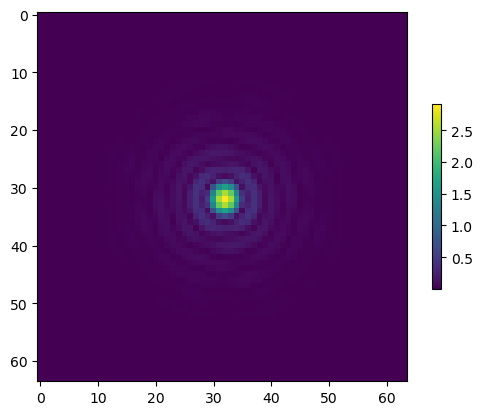

In [26]:
i = 1
im = plt.imshow(fw_diff_cpu[i,0].abs())
plt.colorbar(im, shrink = 0.5)